<a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Run the code using GPU runtime for fast execution of code

Clone the Github Repo

In [1]:
!git clone 'https://github.com/havelhakimi/IterMiunet.git'

Cloning into 'IterMiunet'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 155 (delta 87), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (155/155), 67.53 MiB | 3.20 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Checking out files: 100% (100/100), done.


Run the below cell to create a script: help_functions.py

In [2]:
%%writefile help_functions.py
#@title
import h5py
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
 
def load_hdf5(infile):
  with h5py.File(infile,"r") as f:  #"with" close the file after its nested commands
    return f["image"][()]
 
def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)
 
#convert RGB image in black and white
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    bn_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb.shape[0],1,rgb.shape[2],rgb.shape[3]))
    return bn_imgs
 
#group a set of images row per columns
def group_images(data,per_row):
    assert data.shape[0]%per_row==0
    assert (data.shape[1]==1 or data.shape[1]==3)
    data = np.transpose(data,(0,2,3,1))  #corect format for imshow
    all_stripe = []
    for i in range(int(data.shape[0]/per_row)):
        stripe = data[i*per_row]
        for k in range(i*per_row+1, i*per_row+per_row):
            stripe = np.concatenate((stripe,data[k]),axis=1)
        all_stripe.append(stripe)
    totimg = all_stripe[0]
    for i in range(1,len(all_stripe)):
        totimg = np.concatenate((totimg,all_stripe[i]),axis=0)
    return totimg
 
 
#visualize image (as PIL image, NOT as matplotlib!)
def visualize(data,filename):
    assert (len(data.shape)==3) #height*width*channels
    img = None
    if data.shape[2]==1:  #in case it is black and white
        data = np.reshape(data,(data.shape[0],data.shape[1]))
    if np.max(data)>1:
        img = Image.fromarray(data.astype(np.uint8))   #the image is already 0-255
    else:
        img = Image.fromarray((data*255).astype(np.uint8))  #the image is between 0-1
    img.save(filename + '.png')
    return img
 
 
#prepare the mask in the right shape for the Unet
def masks_Unet(masks):
    assert (len(masks.shape)==4)  #4D arrays
    assert (masks.shape[1]==1 )  #check the channel is 1
    im_h = masks.shape[2]
    im_w = masks.shape[3]
    masks = np.reshape(masks,(masks.shape[0],im_h*im_w))
    new_masks = np.empty((masks.shape[0],im_h*im_w,2))
    for i in range(masks.shape[0]):
        for j in range(im_h*im_w):
            if  masks[i,j] == 0:
                new_masks[i,j,0]=1
                new_masks[i,j,1]=0
            else:
                new_masks[i,j,0]=0
                new_masks[i,j,1]=1
    return new_masks
 
 
def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    assert (len(pred.shape)==3)  #3D array: (Npatches,height*width,2)
    assert (pred.shape[2]==2 )  #check the classes are 2
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  #(Npatches,height*width)
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1]
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                if pred[i,pix,1]>=0.5:
                    pred_images[i,pix]=1
                else:
                    pred_images[i,pix]=0
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images

Writing help_functions.py


Run the below cell to create a script: pre_processing.py

In [3]:
%%writefile pre_processing.py
#@title
#******************************************************************************************
 
###################################################
#
#   Script to pre-process the original imgs
#
##################################################
 
 
import numpy as np
from PIL import Image
import cv2
 
from help_functions import *
 
 
#My pre processing (use for both training and testing!)
def my_PreProc(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    #my preprocessing:
    train_imgs = dataset_normalized(train_imgs)
    train_imgs = clahe_equalized(train_imgs)
    train_imgs = adjust_gamma(train_imgs, 1.2)
    train_imgs = train_imgs/255.  #reduce to 0-1 range
    return train_imgs
 
 
#============================================================
#========= PRE PROCESSING FUNCTIONS ========================#
#============================================================
 
#==== histogram equalization
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized
 
 
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized
 
 
# ===== normalize over the dataset
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized
 
 
def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs

def visualiz(data,filename):
    assert (len(data.shape)==3) #height*width*channels
    img = None
    data = np.transpose(data,(1,2,0)) 
    if data.shape[2]==1:  #in case it is black and white
        data = np.reshape(data,(data.shape[0],data.shape[1]))
    if np.max(data)>1:
        img = Image.fromarray(data.astype(np.uint8))   #the image is already 0-255
    else:
        img = Image.fromarray((data*255).astype(np.uint8))  #the image is between 0-1
    img.save(filename + '.png')
    return img

Writing pre_processing.py


Run the below cell to create a script: extract_patches.py

In [4]:
%%writefile extract_patches.py
#@title
import random
import numpy as np
from help_functions import load_hdf5
from pre_processing import my_PreProc

###############################################################################
 
 
#Load the original data and return the extracted patches for training/testing
def get_data_testing(DRIVE_test_imgs_original, DRIVE_test_groudTruth, Imgs_to_test, patch_height, patch_width):
    ### test
    test_imgs_original = load_hdf5(DRIVE_test_imgs_original)
    test_masks = load_hdf5(DRIVE_test_groudTruth)
 
    test_imgs = my_PreProc(test_imgs_original)
    test_masks = test_masks/255.
 
    #extend both images and masks so they can be divided exactly by the patches dimensions
    test_imgs = test_imgs[0:Imgs_to_test,:,:,:]
    test_masks = test_masks[0:Imgs_to_test,:,:,:]
    test_imgs = paint_border(test_imgs,patch_height,patch_width)
    test_masks = paint_border(test_masks,patch_height,patch_width)
 
    data_consistency_check(test_imgs, test_masks)
 
    #check masks are within 0-1
    assert(np.max(test_masks)==1  and np.min(test_masks)==0)
 
    print("\ntest images/masks shape:")
    print(test_imgs.shape)
    print("test images range (min-max): " +str(np.min(test_imgs)) +' - '+str(np.max(test_imgs)))
    print("test masks are within 0-1\n")
 
    #extract the TEST patches from the full images
    patches_imgs_test = extract_ordered(test_imgs,patch_height,patch_width)
    patches_masks_test = extract_ordered(test_masks,patch_height,patch_width)
    data_consistency_check(patches_imgs_test, patches_masks_test)
 
    print("\ntest PATCHES images/masks shape:")
    print(patches_imgs_test.shape)
    print("test PATCHES images range (min-max): " +str(np.min(patches_imgs_test)) +' - '+str(np.max(patches_imgs_test)))
 
    return patches_imgs_test, patches_masks_test
 
 
 
 
# Load the original data and return the extracted patches for testing
# return the ground truth in its original shape
def get_data_testing_overlap(DRIVE_test_imgs_original, DRIVE_test_groudTruth, Imgs_to_test, patch_height, patch_width, stride_height, stride_width):
    ### test
    test_imgs_original = load_hdf5(DRIVE_test_imgs_original)
    test_masks = load_hdf5(DRIVE_test_groudTruth)
 
    test_imgs = my_PreProc(test_imgs_original)
    test_masks = test_masks/255.
    #extend both images and masks so they can be divided exactly by the patches dimensions
    test_imgs = test_imgs[0:Imgs_to_test,:,:,:]
    test_masks = test_masks[0:Imgs_to_test,:,:,:]
    test_imgs = paint_border_overlap(test_imgs, patch_height, patch_width, stride_height, stride_width)
 
    #check masks are within 0-1
    assert(np.max(test_masks)==1  and np.min(test_masks)==0)
 
    print("\ntest images shape:")
    print(test_imgs.shape)
    print("\ntest mask shape:")
    print(test_masks.shape)
    print("test images range (min-max): " +str(np.min(test_imgs)) +' - '+str(np.max(test_imgs)))
    print("test masks are within 0-1\n")
 
    #extract the TEST patches from the full images
    patches_imgs_test = extract_ordered_overlap(test_imgs,patch_height,patch_width,stride_height,stride_width)
 
    print("\ntest PATCHES images shape:")
    print(patches_imgs_test.shape)
    print("test PATCHES images range (min-max): " +str(np.min(patches_imgs_test)) +' - '+str(np.max(patches_imgs_test)))
 
    return patches_imgs_test, test_imgs.shape[2], test_imgs.shape[3], test_masks
 
 
#data consinstency check
def data_consistency_check(imgs,masks):
    assert(len(imgs.shape)==len(masks.shape))
    assert(imgs.shape[0]==masks.shape[0])
    assert(imgs.shape[2]==masks.shape[2])
    assert(imgs.shape[3]==masks.shape[3])
    assert(masks.shape[1]==1)
    assert(imgs.shape[1]==1 or imgs.shape[1]==3)
 
 
#Divide all the full_imgs in pacthes
def extract_ordered(full_imgs, patch_h, patch_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    N_patches_h = int(img_h/patch_h) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_h) +" patches in height, with about " +str(img_h%patch_h) +" pixels left over")
    N_patches_w = int(img_w/patch_w) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_w) +" patches in width, with about " +str(img_w%patch_w) +" pixels left over")
    print("number of patches per image: " +str(N_patches_h*N_patches_w))
    N_patches_tot = (N_patches_h*N_patches_w)*full_imgs.shape[0]
    patches = np.empty((N_patches_tot,full_imgs.shape[1],patch_h,patch_w))
 
    iter_tot = 0   #iter over the total number of patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        for h in range(N_patches_h):
            for w in range(N_patches_w):
                patch = full_imgs[i,:,h*patch_h:(h*patch_h)+patch_h,w*patch_w:(w*patch_w)+patch_w]
                patches[iter_tot]=patch
                iter_tot +=1   #total
    assert (iter_tot==N_patches_tot)
    return patches  #array with all the full_imgs divided in patches
 
 
def paint_border_overlap(full_imgs, patch_h, patch_w, stride_h, stride_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    leftover_h = (img_h-patch_h)%stride_h  #leftover on the h dim
    leftover_w = (img_w-patch_w)%stride_w  #leftover on the w dim
    if (leftover_h != 0):  #change dimension of img_h
        print("\nthe side H is not compatible with the selected stride of " +str(stride_h))
        print("img_h " +str(img_h) + ", patch_h " +str(patch_h) + ", stride_h " +str(stride_h))
        print("(img_h - patch_h) MOD stride_h: " +str(leftover_h))
        print("So the H dim will be padded with additional " +str(stride_h - leftover_h) + " pixels")
        tmp_full_imgs = np.zeros((full_imgs.shape[0],full_imgs.shape[1],img_h+(stride_h-leftover_h),img_w))
        tmp_full_imgs[0:full_imgs.shape[0],0:full_imgs.shape[1],0:img_h,0:img_w] = full_imgs
        full_imgs = tmp_full_imgs
    if (leftover_w != 0):   #change dimension of img_w
        print("the side W is not compatible with the selected stride of " +str(stride_w))
        print("img_w " +str(img_w) + ", patch_w " +str(patch_w) + ", stride_w " +str(stride_w))
        print("(img_w - patch_w) MOD stride_w: " +str(leftover_w))
        print("So the W dim will be padded with additional " +str(stride_w - leftover_w) + " pixels")
        tmp_full_imgs = np.zeros((full_imgs.shape[0],full_imgs.shape[1],full_imgs.shape[2],img_w+(stride_w - leftover_w)))
        tmp_full_imgs[0:full_imgs.shape[0],0:full_imgs.shape[1],0:full_imgs.shape[2],0:img_w] = full_imgs
        full_imgs = tmp_full_imgs
    print("new full images shape: \n" +str(full_imgs.shape))
    return full_imgs
 
#Divide all the full_imgs in pacthes
def extract_ordered_overlap(full_imgs, patch_h, patch_w,stride_h,stride_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    assert ((img_h-patch_h)%stride_h==0 and (img_w-patch_w)%stride_w==0)
    N_patches_img = ((img_h-patch_h)//stride_h+1)*((img_w-patch_w)//stride_w+1)  #// --> division between integers
    N_patches_tot = N_patches_img*full_imgs.shape[0]
    #print("Number of patches on h : " +str(((img_h-patch_h)//stride_h+1))
    #print("Number of patches on w : " +str(((img_w-patch_w)//stride_w+1)))
    print("number of patches per image: " +str(N_patches_img) +", totally for this dataset: " +str(N_patches_tot))
    patches = np.empty((N_patches_tot,full_imgs.shape[1],patch_h,patch_w))
    iter_tot = 0   #iter over the total number of patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        for h in range((img_h-patch_h)//stride_h+1):
            for w in range((img_w-patch_w)//stride_w+1):
                patch = full_imgs[i,:,h*stride_h:(h*stride_h)+patch_h,w*stride_w:(w*stride_w)+patch_w]
                patches[iter_tot]=patch
                iter_tot +=1   #total
    assert (iter_tot==N_patches_tot)
    return patches  #array with all the full_imgs divided in patches
 
 
def recompone_overlap(preds, img_h, img_w, stride_h, stride_w):
    assert (len(preds.shape)==4)  #4D arrays
    assert (preds.shape[1]==1 or preds.shape[1]==3)  #check the channel is 1 or 3
    patch_h = preds.shape[2]
    patch_w = preds.shape[3]
    N_patches_h = (img_h-patch_h)//stride_h+1
    N_patches_w = (img_w-patch_w)//stride_w+1
    N_patches_img = N_patches_h * N_patches_w
    print("N_patches_h: " +str(N_patches_h))
    print("N_patches_w: " +str(N_patches_w))
    print("N_patches_img: " +str(N_patches_img))
    assert (preds.shape[0]%N_patches_img==0)
    N_full_imgs = preds.shape[0]//N_patches_img
    print("According to the dimension inserted, there are " +str(N_full_imgs) +" full images (of " +str(img_h)+"x" +str(img_w) +" each)")
    full_prob = np.zeros((N_full_imgs,preds.shape[1],img_h,img_w))  #itialize to zero mega array with sum of Probabilities
    full_sum = np.zeros((N_full_imgs,preds.shape[1],img_h,img_w))
 
    k = 0 #iterator over all the patches
    for i in range(N_full_imgs):
        for h in range((img_h-patch_h)//stride_h+1):
            for w in range((img_w-patch_w)//stride_w+1):
                full_prob[i,:,h*stride_h:(h*stride_h)+patch_h,w*stride_w:(w*stride_w)+patch_w]+=preds[k]
                full_sum[i,:,h*stride_h:(h*stride_h)+patch_h,w*stride_w:(w*stride_w)+patch_w]+=1
                k+=1
    assert(k==preds.shape[0])
    assert(np.min(full_sum)>=1.0)  #at least one
    final_avg = full_prob/full_sum
    print(final_avg.shape)
    assert(np.max(final_avg)<=1.0) #max value for a pixel is 1.0
    assert(np.min(final_avg)>=0.0) #min value for a pixel is 0.0
    return final_avg
 
 
#Recompone the full images with the patches
def recompone(data,N_h,N_w):
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    assert(len(data.shape)==4)
    N_pacth_per_img = N_w*N_h
    assert(data.shape[0]%N_pacth_per_img == 0)
    N_full_imgs = data.shape[0]/N_pacth_per_img
    patch_h = data.shape[2]
    patch_w = data.shape[3]
    N_pacth_per_img = N_w*N_h
    #define and start full recompone
    full_recomp = np.empty((N_full_imgs,data.shape[1],N_h*patch_h,N_w*patch_w))
    k = 0  #iter full img
    s = 0  #iter single patch
    while (s<data.shape[0]):
        #recompone one:
        single_recon = np.empty((data.shape[1],N_h*patch_h,N_w*patch_w))
        for h in range(N_h):
            for w in range(N_w):
                single_recon[:,h*patch_h:(h*patch_h)+patch_h,w*patch_w:(w*patch_w)+patch_w]=data[s]
                s+=1
        full_recomp[k]=single_recon
        k+=1
    assert (k==N_full_imgs)
    return full_recomp
 
 
#Extend the full images because patch divison is not exact
def paint_border(data,patch_h,patch_w):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    img_h=data.shape[2]
    img_w=data.shape[3]
    new_img_h = 0
    new_img_w = 0
    if (img_h%patch_h)==0:
        new_img_h = img_h
    else:
        new_img_h = ((int(img_h)/int(patch_h))+1)*patch_h
    if (img_w%patch_w)==0:
        new_img_w = img_w
    else:
        new_img_w = ((int(img_w)/int(patch_w))+1)*patch_w
    new_data = np.zeros((data.shape[0],data.shape[1],new_img_h,new_img_w))
    new_data[:,:,0:img_h,0:img_w] = data[:,:,:,:]
    return new_data
 
 
#return only the pixels contained in the FOV, for both images and masks
def pred_only_FOV(data_imgs,data_masks,original_imgs_border_masks):
    assert (len(data_imgs.shape)==4 and len(data_masks.shape)==4)  #4D arrays
    assert (data_imgs.shape[0]==data_masks.shape[0])
    assert (data_imgs.shape[2]==data_masks.shape[2])
    assert (data_imgs.shape[3]==data_masks.shape[3])
    assert (data_imgs.shape[1]==1 and data_masks.shape[1]==1)  #check the channel is 1
    height = data_imgs.shape[2]
    width = data_imgs.shape[3]
    new_pred_imgs = []
    new_pred_masks = []
    for i in range(data_imgs.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==True:
                    new_pred_imgs.append(data_imgs[i,:,y,x])
                    new_pred_masks.append(data_masks[i,:,y,x])
    new_pred_imgs = np.asarray(new_pred_imgs)
    new_pred_masks = np.asarray(new_pred_masks)
    return new_pred_imgs, new_pred_masks
 
#function to set to black everything outside the FOV, in a full image
def kill_border(data, original_imgs_border_masks):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    height = data.shape[2]
    width = data.shape[3]
    for i in range(data.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==False:
                    data[i,:,y,x]=0.0
 
 
def inside_FOV_DRIVE(i, x, y, DRIVE_masks):
    assert (len(DRIVE_masks.shape)==4)  #4D arrays
    assert (DRIVE_masks.shape[1]==1)  #DRIVE masks is black and white
    # DRIVE_masks = DRIVE_masks/255.  #NOOO!! otherwise with float numbers takes forever!!
 
    if (x >= DRIVE_masks.shape[3] or y >= DRIVE_masks.shape[2]): #my image bigger than the original
        return False
 
    if (DRIVE_masks[i,0,y,x]>0):  #0==black pixels
        # print DRIVE_masks[i,0,y,x]  #verify it is working right
        return True
    else:
        return False
        

Writing extract_patches.py


#Testing on Stare dataset

In [5]:
ROOT_DIR = "."
seg_images_path = os.path.join(ROOT_DIR,'Itermiunetseg')
norm_images_path=os.path.join(ROOT_DIR,'normalizedimg')
os.mkdir(seg_images_path)
os.mkdir(norm_images_path)



Running the model

In [6]:
from keras.models import  load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from help_functions import load_hdf5
from pre_processing import my_PreProc ,visualiz
from extract_patches import get_data_testing_overlap, recompone_overlap, kill_border, pred_only_FOV
import numpy as np
import os



auc=[]
sens=[]
spec=[]
acc=[]
jcc=[]
fratio=[]
dicee=[]

filename=['im0001.ppm','im0002.ppm','im0003.ppm', 'im0004.ppm','im0005.ppm','im0044.ppm','im0077.ppm','im0081.ppm','im0082.ppm', 'im0139.ppm',
 'im0162.ppm',
 'im0163.ppm',
 'im0235.ppm',
 'im0236.ppm',
 'im0239.ppm',
 'im0240.ppm',
 'im0255.ppm',
 'im0291.ppm',
 'im0319.ppm',
 'im0324.ppm']

for p in range(20):


  stride_height = 5
  stride_width = 5

  test_imgs_original = 'Stare_dataset_imgs_test'+filename[p][0:6]+'.hdf5'
  test_groundTruth = 'Stare_dataset_groundtruth_test'+filename[p][0:6]+'.hdf5'
  test_border_masks = 'Stare_dataset_bordermask_test'+filename[p][0:6]+'.hdf5'
  path_data='/content/IterMiunet/Stare/testdata/'
  
  DRIVE_test_imgs_original=path_data+test_imgs_original
  DRIVE_test_border_masks=path_data+test_border_masks
  DRIVE_test_groudTruth =path_data+test_groundTruth
  


  patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
          DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
          DRIVE_test_groudTruth = DRIVE_test_groudTruth ,  #masks
          Imgs_to_test = 1,
          patch_height = 48,
          patch_width = 48,
          stride_height = stride_height,
          stride_width = stride_width
      )

  model=load_model('/content/IterMiunet/Stare/Models/Stareiternet'+filename[p][0:6]+'.keras')

 
 
  patches_imgs_test=np.transpose(patches_imgs_test,(0,2,3,1)) 
  predictions = model.predict(patches_imgs_test, batch_size=64,verbose=1)
  patches_imgs_test=np.transpose(patches_imgs_test,(0,3,1,2)) 
  predictions=np.transpose(predictions,(0,3,1,2))

  test_imgs_orig=load_hdf5(DRIVE_test_imgs_original)
  test_border_masks = load_hdf5(DRIVE_test_border_masks)
  full_img_height = test_imgs_orig.shape[2]
  full_img_width = test_imgs_orig.shape[3]
  
  
  pred_imgs = recompone_overlap(predictions, new_height, new_width, stride_height, stride_width)# predictions
  orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
  gtruth_masks = masks_test  #ground truth masks
  del masks_test
  kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
  orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
  pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
  gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]


  img=pred_imgs[0].copy()
  img[img>=0.5]=1
  img[img<0.5]=0
  path1=os.path.join(seg_images_path,"itermiunet_seg_"+filename[p][0:6])
  path2=os.path.join(norm_images_path,"norm_img_"+filename[p][0:6])
  visualiz(img,path1)
  visualiz(orig_imgs[0],path2)
  

  print("\n\n========  Evaluate the results =======================)")
  #predictions only inside the FOV
  y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks, test_border_masks)  #returns data only inside the FOV

  fpr, tpr, thresholds = roc_curve((y_true), y_scores)
  
  #AUC
  AUC_ROC = roc_auc_score(y_true, y_scores)
  print("\nArea under the ROC curve: " +str(AUC_ROC))
  auc.append(str(AUC_ROC))

  # hard thresholding of 0.5
  threshold_confusion = 0.5
  print("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
  y_pred = np.empty((y_scores.shape[0]))
  for i in range(y_scores.shape[0]):
      if y_scores[i]>=threshold_confusion:
          y_pred[i]=1
      else:
          y_pred[i]=0
  
  #confusion matrix
  confusion = confusion_matrix(y_true, y_pred)
  
  # accuracy
  accuracy = 0
  if float(np.sum(confusion))!=0:
      accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
  acc.append(str(accuracy))
  
  #specificity
  specificity = 0
  if float(confusion[0,0]+confusion[0,1])!=0:
      specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
  spec.append(str(specificity))
  
  # sensitivity
  sensitivity = 0
  if float(confusion[1,1]+confusion[1,0])!=0:
      sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
  sens.append(str(sensitivity))
  
  #F1 score
  F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
  fratio.append(str(F1_score))
  
  
  print("finised for "+filename[p][0:6])
  del patches_imgs_test
  del new_height
  del new_width
  del model




the side H is not compatible with the selected stride of 5
img_h 605, patch_h 48, stride_h 5
(img_h - patch_h) MOD stride_h: 2
So the H dim will be padded with additional 3 pixels
the side W is not compatible with the selected stride of 5
img_w 700, patch_w 48, stride_w 5
(img_w - patch_w) MOD stride_w: 2
So the W dim will be padded with additional 3 pixels
new full images shape: 
(1, 1, 608, 703)

test images shape:
(1, 1, 608, 703)

test mask shape:
(1, 1, 605, 700)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

number of patches per image: 14916, totally for this dataset: 14916

test PATCHES images shape:
(14916, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0
234/234 [==============================] - 31s 89ms/step
N_patches_h: 113
N_patches_w: 132
N_patches_img: 14916
According to the dimension inserted, there are 1 full images (of 608x703 each)
(1, 1, 608, 703)


========  Evaluate the results =======================)

Area under the ROC curve: 0.978

Metrics

In [7]:
for i in range(len(sens)):
  sens[i]=float(sens[i][0:6])

for i in range(len(spec)):
  spec[i]=float(spec[i][0:6])

for i in range(len(auc)):
  auc[i]=float(auc[i][0:6])
for i in range(len(acc)):
  acc[i]=float(acc[i][0:6])

for i in range(len(fratio)):
  fratio[i]=float(fratio[i][0:6])


print(np.mean(auc).round(4),np.std(auc).round(4))
print(np.mean(sens).round(4),np.std(sens).round(4))
print(np.mean(spec).round(4),np.std(spec).round(4))
print(np.mean(acc).round(4),np.std(acc).round(4))
print(np.mean(fratio).round(4),np.std(fratio).round(4))



0.9853 0.0086
0.8069 0.0932
0.9832 0.0063
0.9649 0.0096


In [9]:

print(f'AUC:{np.mean(auc).round(4)} with deviation :{np.std(auc).round(4)}\n')
print(f'Sensitivity:{np.mean(sens).round(4)} with deviation :{np.std(sens).round(4)}\n')
print(f'Specificity:{np.mean(spec).round(4)} with deviation :{np.std(spec).round(4)}\n')
print(f'Accuracy:{np.mean(acc).round(4)} with deviation :{np.std(acc).round(4)}\n')
print(f'F-ratio:{np.mean(fratio).round(4)} with deviation :{np.std(fratio).round(4)}')



AUC:0.9853 with deviation :0.0086

Sensitivity:0.8069 with deviation :0.0932

Specificity:0.9832 with deviation :0.0063

Accuracy:0.9649 with deviation :0.0096

F-ratio:0.8231 with deviation :0.0567


Normalized images are saved locally folder 'normalizedimg' nd Segmented images in the folder 'itermiunet' seg. They can be downloaded from there. <br>
Apart from it, drawing subplots of images and corresponding segmentation.


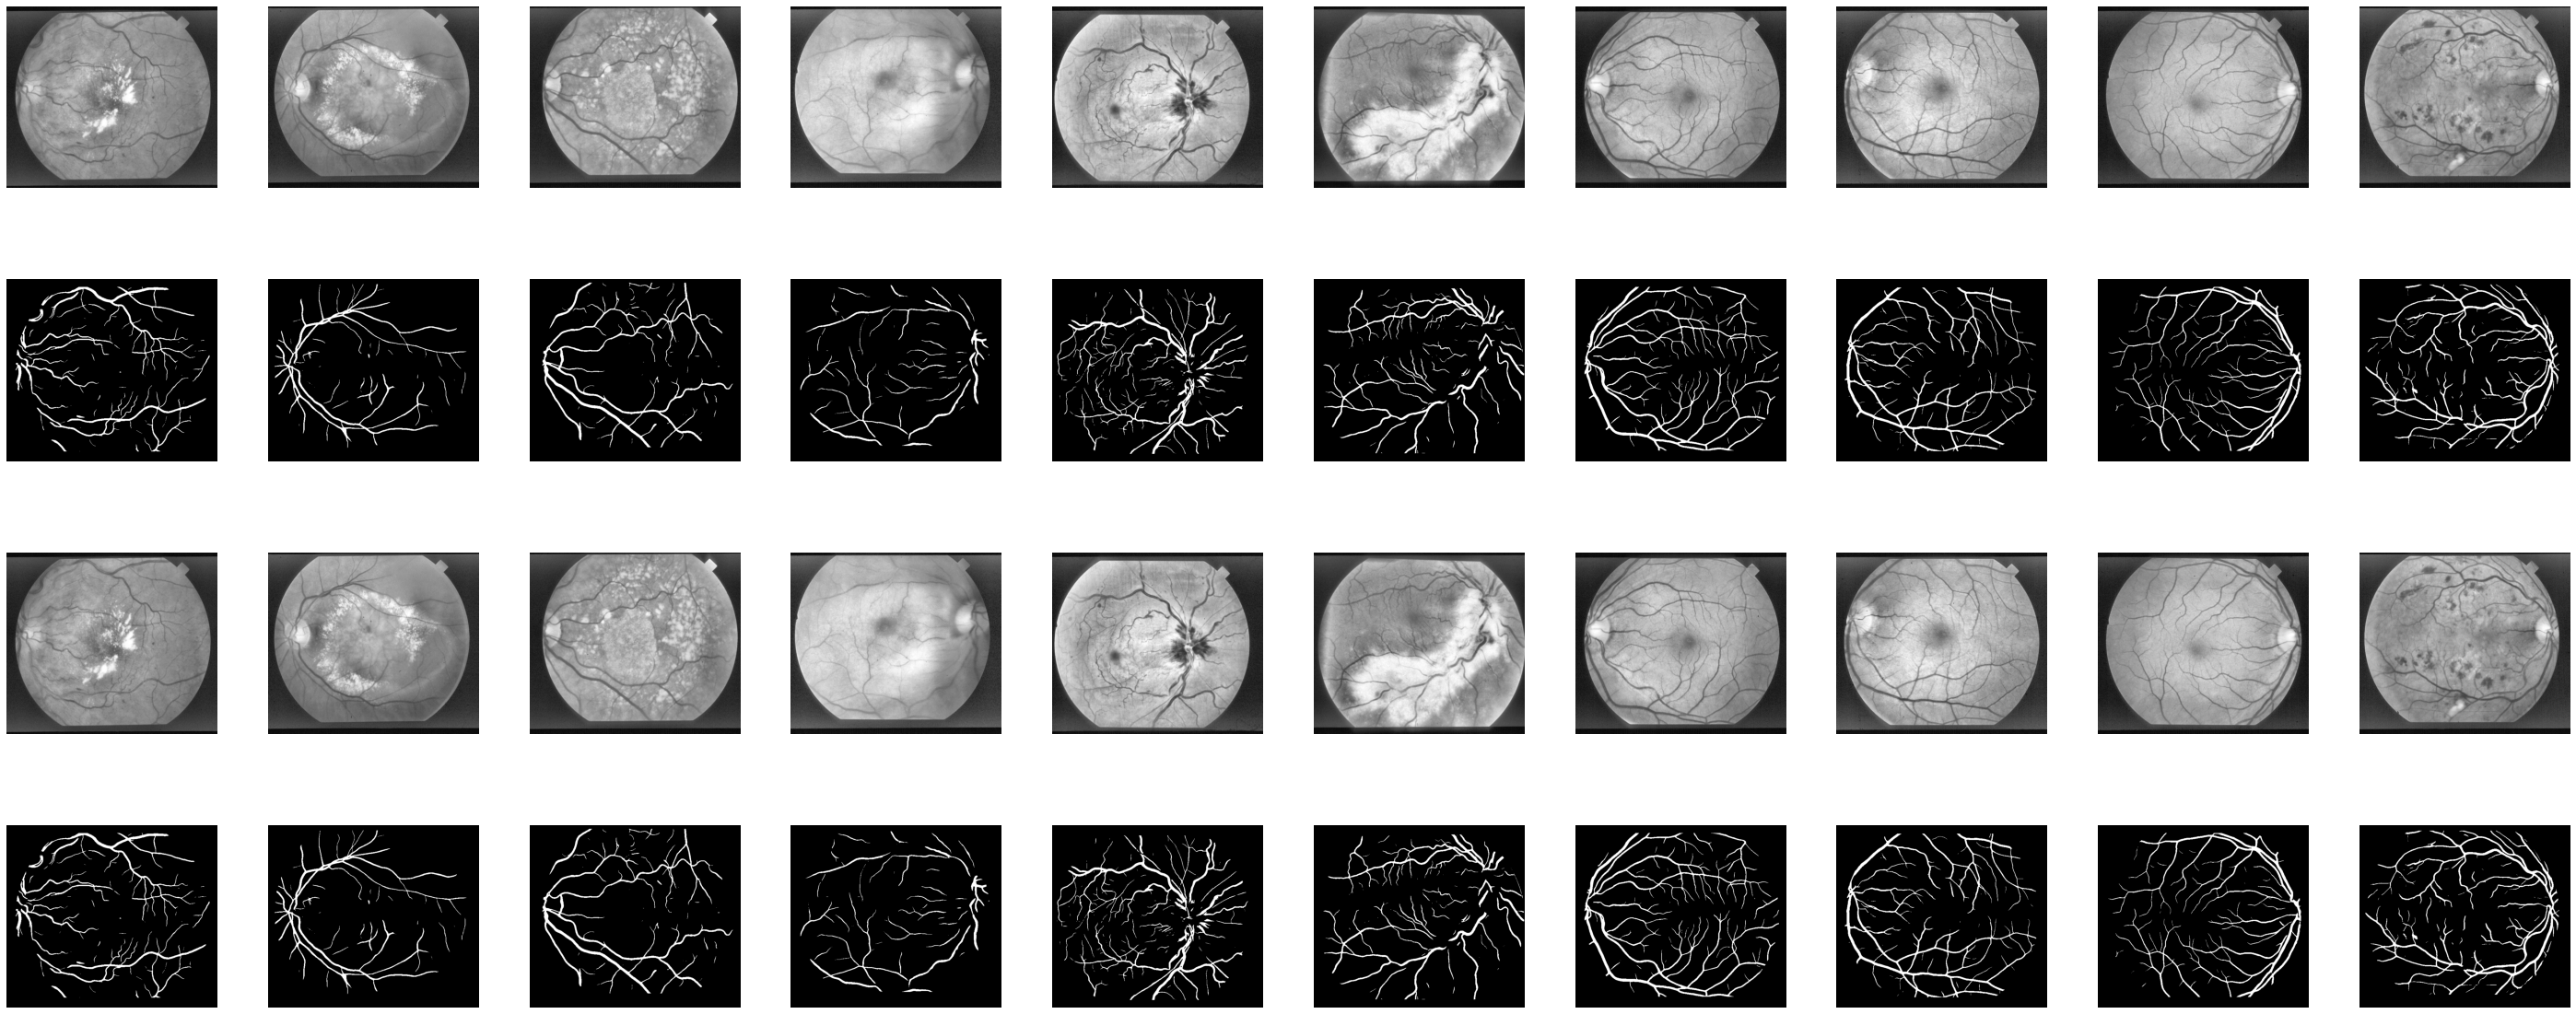

In [35]:
import  matplotlib.pyplot as plt

filename=['im0001.ppm','im0002.ppm','im0003.ppm', 'im0004.ppm','im0005.ppm','im0044.ppm','im0077.ppm','im0081.ppm','im0082.ppm', 'im0139.ppm',
 'im0162.ppm',
 'im0163.ppm',
 'im0235.ppm',
 'im0236.ppm',
 'im0239.ppm',
 'im0240.ppm',
 'im0255.ppm',
 'im0291.ppm',
 'im0319.ppm',
 'im0324.ppm']
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows,n_cols,index+1)
    if index<10:
      img=plt.imread('/content/normalizedimg/norm_img_'+ filename[index][0:6]+'.png')
      plt.imshow(img,cmap='gray')
    elif index>=10 and index<20:
      idx=index-10
      img=plt.imread('/content/Itermiunetseg/itermiunet_seg_'+ filename[idx][0:6]+'.png')
      plt.imshow(img,cmap='gray')
    elif index>=20 and index<30:
      idx=index-20
      img=plt.imread('/content/normalizedimg/norm_img_'+ filename[idx][0:6]+'.png')
      plt.imshow(img,cmap='gray')
    
    else:
      idx=index-30
      img=plt.imread('/content/Itermiunetseg/itermiunet_seg_'+ filename[idx][0:6]+'.png')
      plt.imshow(img,cmap='gray')

    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)


#InterRaterVariability 
Trained on first ground truth but tested on second groundtruth

In [36]:
from keras.models import  load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from help_functions import load_hdf5
from pre_processing import my_PreProc ,visualiz
from extract_patches import get_data_testing_overlap, recompone_overlap, kill_border, pred_only_FOV
import numpy as np
import os



auc=[]
sens=[]
spec=[]
acc=[]
jcc=[]
fratio=[]
dicee=[]

filename=['im0001.ppm','im0002.ppm','im0003.ppm', 'im0004.ppm','im0005.ppm','im0044.ppm','im0077.ppm','im0081.ppm','im0082.ppm', 'im0139.ppm',
 'im0162.ppm',
 'im0163.ppm',
 'im0235.ppm',
 'im0236.ppm',
 'im0239.ppm',
 'im0240.ppm',
 'im0255.ppm',
 'im0291.ppm',
 'im0319.ppm',
 'im0324.ppm']

for p in range(20):


  stride_height = 5
  stride_width = 5

  test_imgs_original = 'Stare_dataset_imgs_test'+filename[p][0:6]+'.hdf5'
  #trained on Hoover annotations and tested on VK annotations 
  test_groundTruth = 'Stare_dataset_vkgroundtruth_test'+filename[p][0:6]+'.vk.ppm.hdf5'
  test_border_masks = 'Stare_dataset_bordermask_test'+filename[p][0:6]+'.hdf5' 
  path_data_1='/content/IterMiunet/Stare/testdata/'
  path_data_2='/content/IterMiunet/Stare/staregroundtruth/'

  
  DRIVE_test_imgs_original=path_data_1+test_imgs_original
  DRIVE_test_border_masks=path_data_1+test_border_masks
  DRIVE_test_groudTruth =path_data_2+test_groundTruth
  


  patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
          DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
          DRIVE_test_groudTruth = DRIVE_test_groudTruth ,  #masks
          Imgs_to_test = 1,
          patch_height = 48,
          patch_width = 48,
          stride_height = stride_height,
          stride_width = stride_width
      )

  model=load_model('/content/IterMiunet/Stare/Models/Stareiternet'+filename[p][0:6]+'.keras')

 
 
  patches_imgs_test=np.transpose(patches_imgs_test,(0,2,3,1)) 
  predictions = model.predict(patches_imgs_test, batch_size=64,verbose=1)
  patches_imgs_test=np.transpose(patches_imgs_test,(0,3,1,2)) 
  predictions=np.transpose(predictions,(0,3,1,2))

  test_imgs_orig=load_hdf5(DRIVE_test_imgs_original)
  test_border_masks = load_hdf5(DRIVE_test_border_masks)
  full_img_height = test_imgs_orig.shape[2]
  full_img_width = test_imgs_orig.shape[3]
  
  
  pred_imgs = recompone_overlap(predictions, new_height, new_width, stride_height, stride_width)# predictions
  orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
  gtruth_masks = masks_test  #ground truth masks
  del masks_test
  kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
  orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
  pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
  gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]


  img=pred_imgs[0].copy()
  img[img>=0.5]=1
  img[img<0.5]=0
  path1=os.path.join(seg_images_path,"itermiunet_seg_"+filename[p][0:6])
  path2=os.path.join(norm_images_path,"norm_img_"+filename[p][0:6])
  visualiz(img,path1)
  visualiz(orig_imgs[0],path2)
  

  print("\n\n========  Evaluate the results =======================)")
  #predictions only inside the FOV
  y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks, test_border_masks)  #returns data only inside the FOV

  fpr, tpr, thresholds = roc_curve((y_true), y_scores)
  
  #AUC
  AUC_ROC = roc_auc_score(y_true, y_scores)
  print("\nArea under the ROC curve: " +str(AUC_ROC))
  auc.append(str(AUC_ROC))

  # hard thresholding of 0.5
  threshold_confusion = 0.5
  print("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
  y_pred = np.empty((y_scores.shape[0]))
  for i in range(y_scores.shape[0]):
      if y_scores[i]>=threshold_confusion:
          y_pred[i]=1
      else:
          y_pred[i]=0
  
  #confusion matrix
  confusion = confusion_matrix(y_true, y_pred)
  
  # accuracy
  accuracy = 0
  if float(np.sum(confusion))!=0:
      accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
  acc.append(str(accuracy))
  
  #specificity
  specificity = 0
  if float(confusion[0,0]+confusion[0,1])!=0:
      specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
  spec.append(str(specificity))
  
  # sensitivity
  sensitivity = 0
  if float(confusion[1,1]+confusion[1,0])!=0:
      sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
  sens.append(str(sensitivity))
  
  #F1 score
  F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
  fratio.append(str(F1_score))
  
  
  print("finised for "+filename[p][0:6])
  del patches_imgs_test
  del new_height
  del new_width
  del model




the side H is not compatible with the selected stride of 5
img_h 605, patch_h 48, stride_h 5
(img_h - patch_h) MOD stride_h: 2
So the H dim will be padded with additional 3 pixels
the side W is not compatible with the selected stride of 5
img_w 700, patch_w 48, stride_w 5
(img_w - patch_w) MOD stride_w: 2
So the W dim will be padded with additional 3 pixels
new full images shape: 
(1, 1, 608, 703)

test images shape:
(1, 1, 608, 703)

test mask shape:
(1, 1, 605, 700)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

number of patches per image: 14916, totally for this dataset: 14916

test PATCHES images shape:
(14916, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0
234/234 [==============================] - 21s 87ms/step
N_patches_h: 113
N_patches_w: 132
N_patches_img: 14916
According to the dimension inserted, there are 1 full images (of 608x703 each)
(1, 1, 608, 703)


========  Evaluate the results =======================)

Area under the ROC curve: 0.965

In [37]:
for i in range(len(sens)):
  sens[i]=float(sens[i][0:6])

for i in range(len(spec)):
  spec[i]=float(spec[i][0:6])

for i in range(len(auc)):
  auc[i]=float(auc[i][0:6])
for i in range(len(acc)):
  acc[i]=float(acc[i][0:6])

for i in range(len(fratio)):
  fratio[i]=float(fratio[i][0:6])





In [39]:
print(f'AUC:{np.mean(auc).round(4)} with deviation :{np.std(auc).round(4)}\n')
print(f'Sensitivity:{np.mean(sens).round(4)} with deviation :{np.std(sens).round(4)}\n')
print(f'Specificity:{np.mean(spec).round(4)} with deviation :{np.std(spec).round(4)}\n')
print(f'Accuracy:{np.mean(acc).round(4)} with deviation :{np.std(acc).round(4)}\n')
print(f'F-ratio:{np.mean(fratio).round(4)} with deviation :{np.std(fratio).round(4)}')



AUC:0.9591 with deviation :0.0119

Sensitivity:0.6191 with deviation :0.0561

Specificity:0.9909 with deviation :0.0076

Accuracy:0.9341 with deviation :0.0161

F-ratio:0.732 with deviation :0.0384
